## NLP Resturant Reviews Project

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

# data processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# for reproducibility
seed = 10086

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('/Restaurant reviews.csv')
df

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN
...,...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0,NaN
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,NaN
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,NaN
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0,NaN


In [ ]:
# unnecessary column
df.drop(['7514'], axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [ ]:
# check for duplicate value and drop them if necessary
df.duplicated().sum()

36

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [ ]:
# check for werid value
df['Rating'].value_counts()

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [ ]:
# Replace werid values and finish data cleaning
df['Rating'] = df['Rating'].replace(['Like'], '5')
df['Rating'] = df['Rating'].astype(float)

In [ ]:
# Add a new column named "Label", positive for rating greater than or equal to 3 and negative for rating less than 3
df['Label'] = [1 if x >= 3 else 0 for x in df['Rating']]
df

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,Label
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,"1 Review , 2 Followers",5/25/2019 15:54,0,1
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,"3 Reviews , 2 Followers",5/25/2019 14:20,0,1
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,"2 Reviews , 3 Followers",5/24/2019 22:54,0,1
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,"1 Review , 1 Follower",5/24/2019 22:11,0,1
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,"3 Reviews , 2 Followers",5/24/2019 21:37,0,1
...,...,...,...,...,...,...,...,...
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3.0,"53 Reviews , 54 Followers",6/5/2016 0:08,0,1
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,1
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,0
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4.0,"13 Reviews , 144 Followers",5/31/2016 17:22,0,1


In [ ]:
df_new = df[['Review','Label', 'Rating']].copy()
df_new

,Review,Label,Rating
0,"The ambience was good, food was quite good . h...",1,5.0
1,Ambience is too good for a pleasant evening. S...,1,5.0
2,A must try.. great food great ambience. Thnx f...,1,5.0
3,Soumen das and Arun was a great guy. Only beca...,1,5.0
4,Food is good.we ordered Kodi drumsticks and ba...,1,5.0
...,...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,1,3.0
9996,This place has never disappointed us.. The foo...,1,4.5
9997,"Bad rating is mainly because of ""Chicken Bone ...",0,1.5
9998,I personally love and prefer Chinese Food. Had...,1,4.0


In [ ]:
def preprocess_text(text):
    # remove html tags and keep lowercase alphabetic characters only
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text).lower()

    # tokenize the words
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    preprocessed_text = ' '.join(words)
    return preprocessed_text

In [ ]:
df_new['clean'] = df_new['Review'].astype(str).apply(preprocess_text)

# Textual Analysis

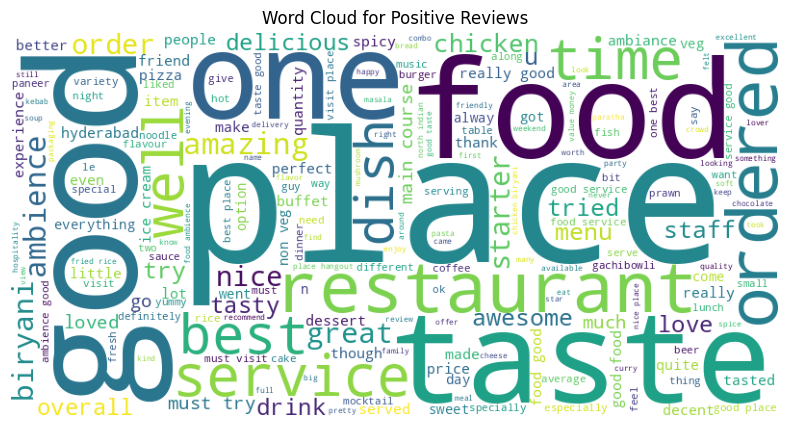

In [ ]:
df_review_pos = df_new[df_new['Label'] == 1]
review_pos = ''.join(df_review_pos['clean'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(review_pos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

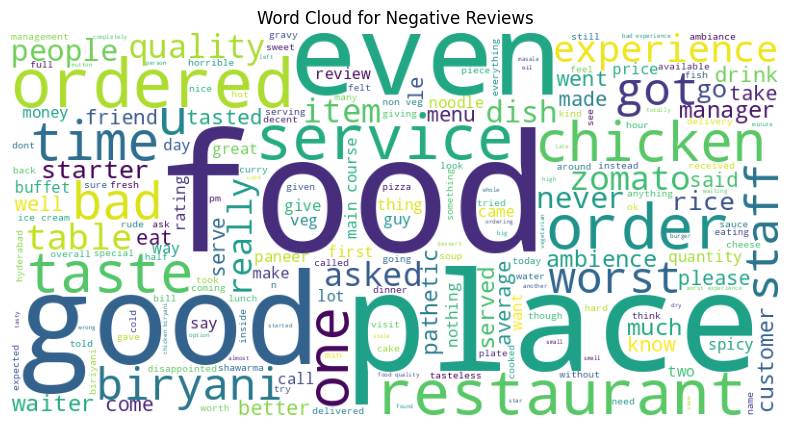

In [ ]:
df_review_neg = df_new[df_new['Label'] == 0]
review_neg = ''.join(df_review_neg['clean'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(review_neg)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

In [ ]:
df['Rating'].value_counts()

5.0    3833
4.0    2373
1.0    1735
3.0    1193
2.0     684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64

In [ ]:
df_review_5star = df_new[df_new['Rating'] == 5]
df_review_5star

,Review,Label,Rating,clean
0,"The ambience was good, food was quite good . h...",1,5.0,ambience good food quite good saturday lunch c...
1,Ambience is too good for a pleasant evening. S...,1,5.0,ambience good pleasant evening service prompt ...
2,A must try.. great food great ambience. Thnx f...,1,5.0,must try great food great ambience thnx servic...
3,Soumen das and Arun was a great guy. Only beca...,1,5.0,soumen da arun great guy behavior sincerety go...
4,Food is good.we ordered Kodi drumsticks and ba...,1,5.0,food good ordered kodi drumstick basket mutton...
...,...,...,...,...
9983,What a delightful place. Food was the star her...,1,5.0,delightful place food star left literally grin...
9990,Amazing food ! I always go here when I want Ch...,1,5.0,amazing food always go want chinese food favou...
9991,I was never a fan of Chinese food until I visi...,1,5.0,never fan chinese food visited chinese pavilio...
9992,I visited this restaurant with friends and was...,1,5.0,visited restaurant friend immediately blown aw...


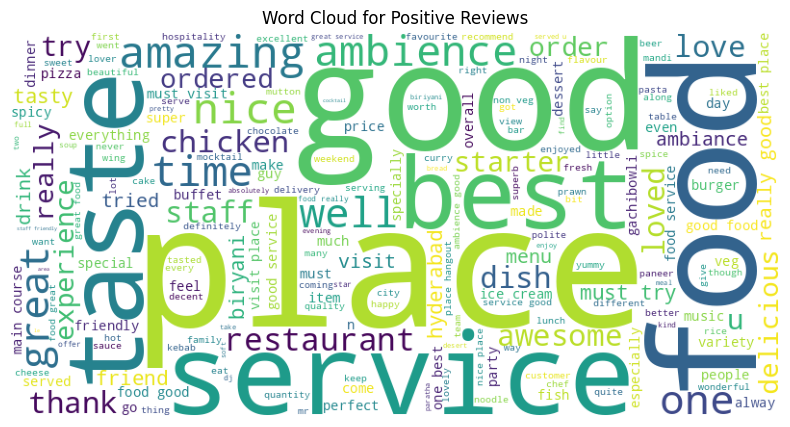

In [ ]:
review_5star = ''.join(df_review_5star['clean'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(review_5star)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

### Word Cloud for the Specific Restaurant: "Beyond Flavours"

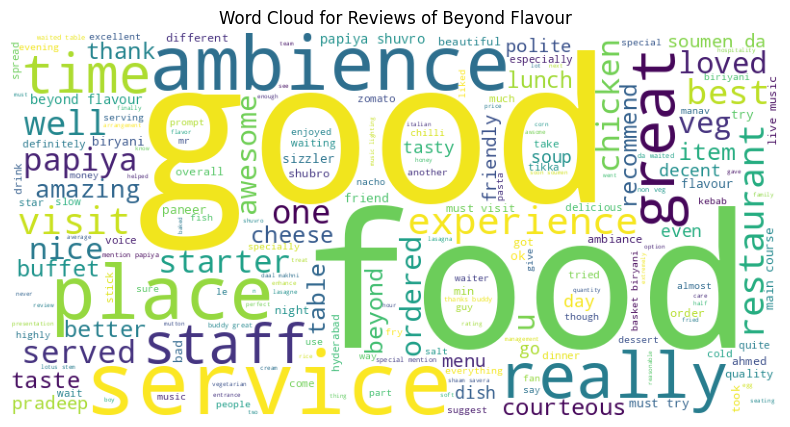

In [ ]:
df['clean'] = df['Review'].astype(str).apply(preprocess_text)
df_beyong_fla = df[df['Restaurant'] == 'Beyond Flavours']
review_beyong_fla = ''.join(df_beyong_fla['clean'])
wordss = WordCloud(width=800, height=400, background_color='white').generate(review_beyong_fla)
plt.figure(figsize=(10, 5))
plt.imshow(wordss)
plt.title('Word Cloud for Reviews of Beyond Flavour')
plt.axis('off')
plt.show()

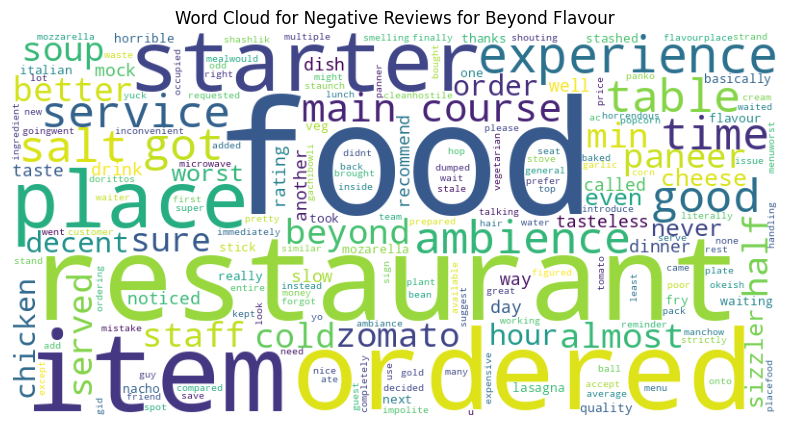

In [ ]:
df_review_neg = df_beyong_fla[df_beyong_fla['Label'] == 0]
review_neg = ''.join(df_review_neg['clean'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(review_neg)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative)
plt.title('Word Cloud for Negative Reviews for Beyond Flavour')
plt.axis('off')
plt.show()

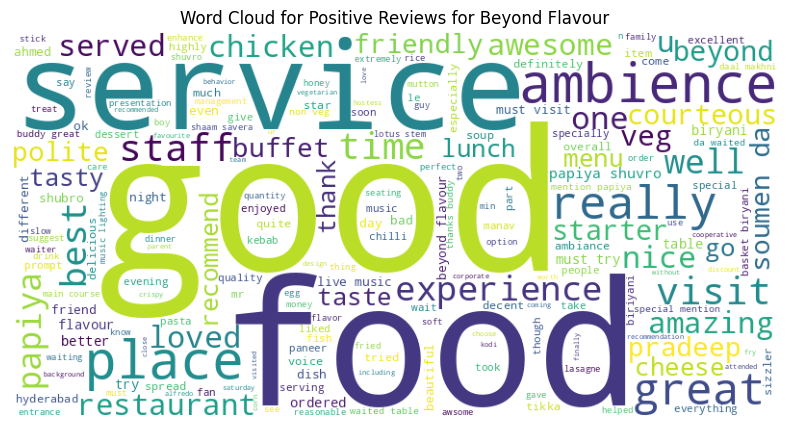

In [ ]:
df_review_pos = df_beyong_fla[df_beyong_fla['Label'] == 1]
review_pos = ''.join(df_review_pos['clean'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(review_pos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive)
plt.title('Word Cloud for Positive Reviews for Beyond Flavour')
plt.axis('off')
plt.show()

### Word Cloud for the specific restaurant: "Driven Cafe"

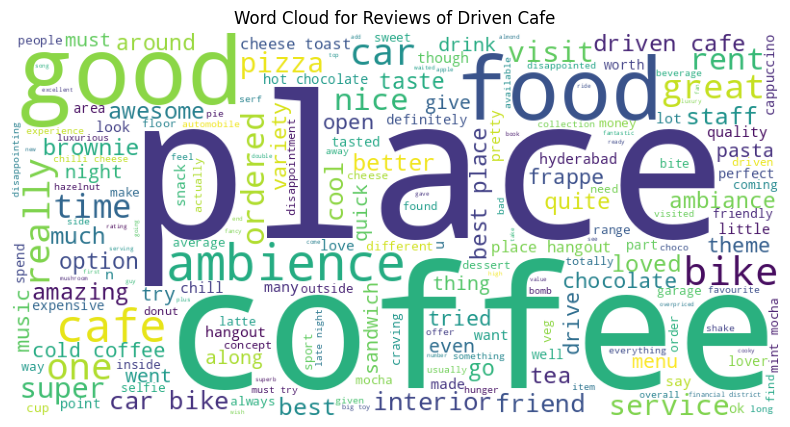

In [ ]:
df_driven_caf = df[df['Restaurant'] == 'Driven Cafe']
review_driven_caf = ''.join(df_driven_caf['clean'])
wordss = WordCloud(width=800, height=400, background_color='white').generate(review_driven_caf)
plt.figure(figsize=(10, 5))
plt.imshow(wordss)
plt.title('Word Cloud for Reviews of Driven Cafe')
plt.axis('off')
plt.show()

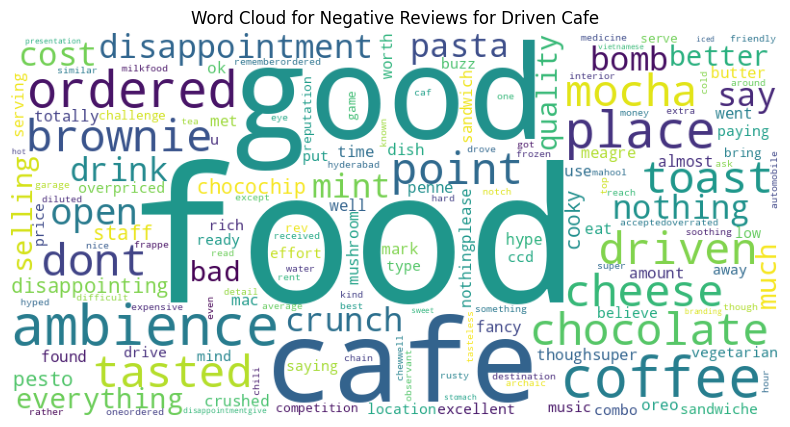

In [ ]:
df_review_neg = df_driven_caf[df_driven_caf['Label'] == 0]
review_neg = ''.join(df_review_neg['clean'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(review_neg)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative)
plt.title('Word Cloud for Negative Reviews for Driven Cafe')
plt.axis('off')
plt.show()

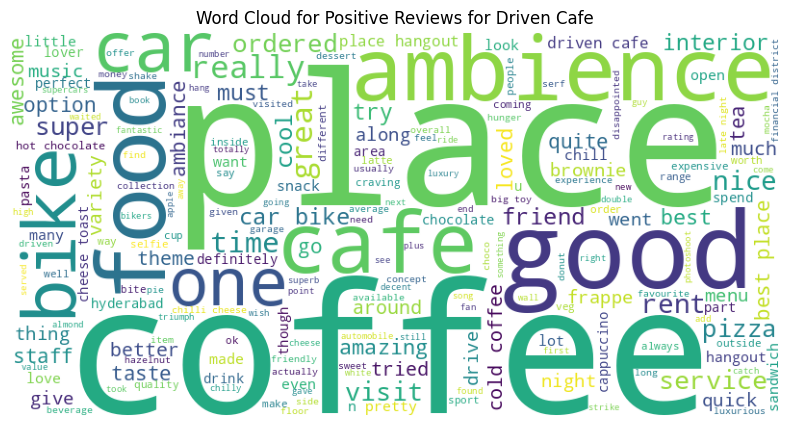

In [ ]:
df_review_pos = df_driven_caf[df_driven_caf['Label'] == 1]
review_pos = ''.join(df_review_pos['clean'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(review_pos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive)
plt.title('Word Cloud for Positive Reviews for Driven Cafe')
plt.axis('off')
plt.show()

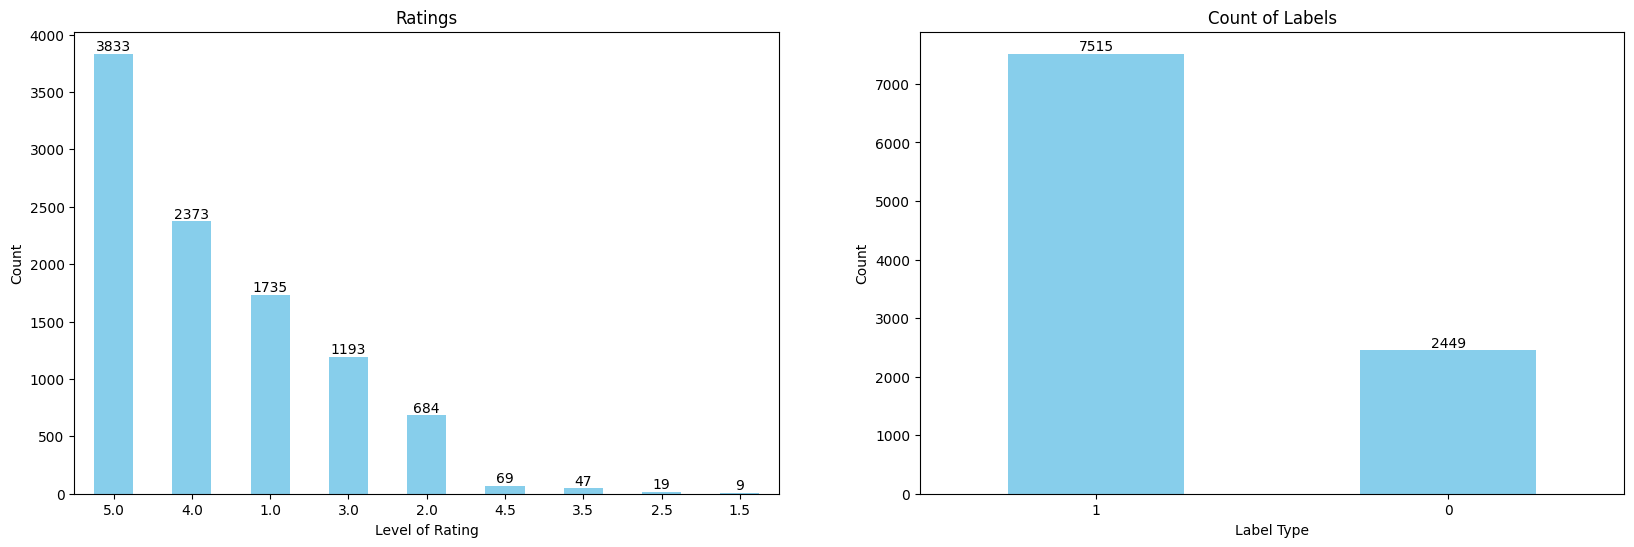

In [ ]:
# Setting the size of the figure
plt.figure(figsize = (20,6))

# Subplot 1: Bar chart for 'Group' column
plt.subplot(1, 2, 1)

# Get the counts of unique valuess in the ratings col
num_ratings = df_new['Rating'].value_counts()

# Plot a bar chart
num_ratings.plot(kind='bar', color='skyblue')

# Setting titles and labels
plt.title('Ratings')
plt.xlabel('Level of Rating')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')

# Add text labels on top of each bar to display the count
for index, value in enumerate(num_ratings):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Subplot 2
plt.subplot(1, 2, 2)
num_label = df_new['Label'].value_counts()
num_label.plot(kind='bar', color='skyblue')

# Setting titles and labels
plt.title('Count of Labels')
plt.xlabel('Label Type')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')

# Add text labels on top of each bar to display the count
for index, value in enumerate(num_label):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')
plt.show()

# Predictive Analysis

In [ ]:
X = df_new['clean'].values
y = df_new['Label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10086)

In [ ]:
# setup automatic grid search for different models
model_info = [
    {'model': RandomForestClassifier(random_state=seed),
     'params': {
         'clf__n_estimators': [100, 200],
         'clf__max_depth': [None, 10, 20],}},
    {'model': AdaBoostClassifier(random_state=seed),
     'params': {
         'clf__n_estimators': [50, 100, 150],
         'clf__learning_rate': [1.0, 0.1, 0.01],}},
    {'model': XGBClassifier(random_state=seed, use_label_encoder=False, eval_metric='mlogloss'),
     'params': {
         'clf__max_depth': [3, 5, 6, 7, 10],
         'clf__n_estimators': [100, 150, 200],
         'clf__learning_rate': [0.1, 0.01],}},
    {'model': SGDClassifier(random_state=seed),
     'params': {
         'clf__loss': ['hinge', 'log'],
         'clf__alpha': [1e-4, 1e-3, 1e-2],
         'clf__penalty': ['l2', 'l1', 'elasticnet']}}
    ]

In [ ]:
# loop through different models and do grid search on each of them
flag = True
if flag:
    for model_dict in model_info:
        pipeline = Pipeline([
            # Vectorizing text data
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
            ('clf', model_dict['model'])
        ])

        # adjust the parameter grid for the current model
        param_grid = model_dict['params']
        for key in list(param_grid.keys()):
            if not key.startswith('clf__'):
                param_grid['clf__' + key] = param_grid.pop(key)

        grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

        print(f"Training model: {model_dict['model'].__class__.__name__}")
        grid_search.fit(X_train, y_train)

        # use the validation and test data sets to evaluate the model
        best_model = grid_search.best_estimator_
        test_score = best_model.score(X_test, y_test)

        y_pred = best_model.predict(X_test)  # Predictions on the test data
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        print(f"Model: {model_dict['model'].__class__.__name__}")
        print(f"Test Score: {test_score}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print("-" * 80)

Training model: RandomForestClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Model: RandomForestClassifier
Test Score: 0.8966382338183643
Precision: 0.8953002207287342
Recall: 0.8966382338183643
Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 200}
--------------------------------------------------------------------------------
Training model: AdaBoostClassifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Model: AdaBoostClassifier
Test Score: 0.8810837932764677
Precision: 0.8785395367605543
Recall: 0.8810837932764677
Best Parameters: {'clf__learning_rate': 1.0, 'clf__n_estimators': 150}
--------------------------------------------------------------------------------
Training model: XGBClassifier
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Model: XGBClassifier
Test Score: 0.8976417461113899
Precision: 0.8952776201792478
Recall: 0.8976417461113899
Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Model: SGDClassifier
Test Score: 0.9036628198695434
Precision: 0.9020500345226116
Recall: 0.9036628198695434
Best Parameters: {'clf__alpha': 0.0001, 'clf__loss': 'log', 'clf__penalty': 'elasticnet'}
--------------------------------------------------------------------------------


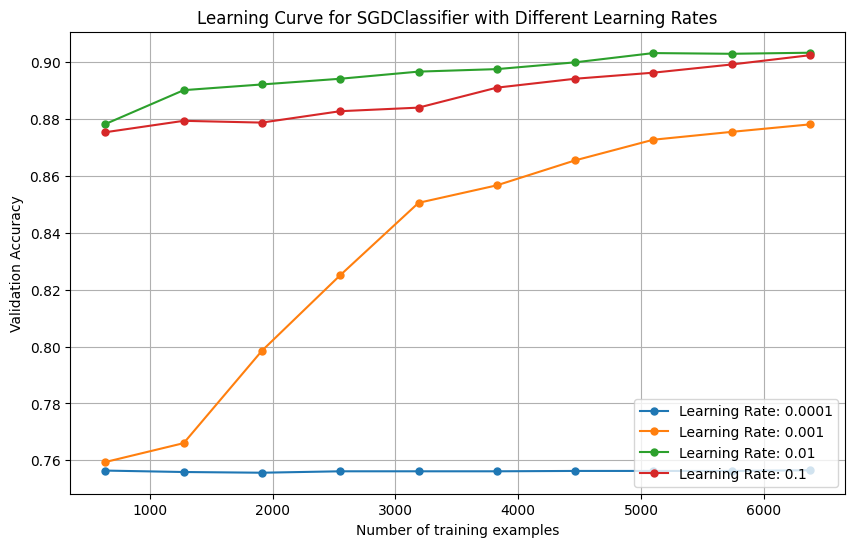

In [ ]:
# Define a range of learning rates to try
learning_rates = [0.0001, 0.001, 0.01, 0.1]

# Create an empty dictionary to store learning curves for different learning rates
learning_curves = {}

for learning_rate in learning_rates:
    # Define the SGDClassifier pipeline with the current learning rate
    sgd_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', SGDClassifier(random_state=seed, alpha=0.0001, penalty='l2', learning_rate='constant', eta0=learning_rate))
    ])

    # Calculate learning curve for the current learning rate
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=sgd_pipeline,
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        n_jobs=-1
    )

    # Store the learning curve for the current learning rate
    learning_curves[learning_rate] = (train_sizes, train_scores, test_scores)

# Plot the learning curves for different learning rates
plt.figure(figsize=(10, 6))
for learning_rate, (train_sizes, train_scores, test_scores) in learning_curves.items():
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, test_mean, linestyle='-', marker='o', markersize=5, label=f'Learning Rate: {learning_rate}')

plt.title('Learning Curve for SGDClassifier with Different Learning Rates')
plt.xlabel('Number of training examples')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show()
